In [1]:
# This code downloads the latest Coronavirus disease 2019 (COVID-19) data from the 
# European Center for Disease Control (ECDC). The ECDC data is in a columnar format,
# so this code transforms the data to have rows with the following columns:
# Columns=Date, Cases, Deaths, Location (Country), GeoID, Population, and Day. 
# The "Day" column is the number of days from when the daily number of cases # and/or deaths exceeds a limit variable. 
# It also creates a few graphs to visualize the data on several different timelines.
import pandas as pd
import numpy as np
import math
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
import urllib

#STEP 1: Load the original CSV file from https://ourworldindata.org/coronavirus-source-data
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-' + date.today().strftime('%Y-%m-%d') + '.xlsx'
fn = 'DATA/ECDC/DAILY/' + date.today().strftime('%Y-%m-%d') + '-JHI-DAILY.xlsx'
urllib.request.urlretrieve(url, fn)
odf = pd.read_excel(fn, encoding='ISO-8859-1')

#Rename and remove columns
odf.rename(columns={ odf.columns[0]: "Date" }, inplace = True)
odf = odf.rename(columns={"cases":"Cases","deaths":"Deaths","countriesAndTerritories":"Location","geoId":"GeoID","popData2019":"Population"})
odf = odf.drop(['day','month','year','countryterritoryCode'],axis=1)

#STEP 2: Load the data for December 2019
ddf = pd.read_csv('DATA/ORIGINAL/2019-12-31-COVID-19-ALL.csv')
ddf = ddf.rename(columns={"DateRep":"Date","Countries and territories":"Location","Pop_Data.2018":"Population"})
ddf = ddf.drop(['Day','Month','Year'],axis=1)

#STEP 3: Load and clean up the data for analysis

#Append the data from December to the data downloaded from ourworldindata.org
df3 = odf.append(ddf)

#Rename and remove columns
#odf = odf.rename(columns={"Countries and territories":"Location","dateRep":"Date","popData2018":"Population"})
#odf = odf.drop(['Day','Month','Year'],axis=1)

#Convert to datetime so it sorts by date, not by string
df3.Date = pd.to_datetime(df3.Date)
df3 = odf.reset_index(drop=True)
df3 = odf.sort_values(by=['Date'])

#STEP 3: Get unique list of locations
locations = pd.DataFrame(df3.Location.unique())
locations = locations.rename(columns={0:"Location"})

#Convert the column so we can easily work with it as a string
locations.Location = locations.Location.astype(str)

#Remove any countries where the maximum number of daily cases has not yet reached at least 100
#The hypothesis behind this step is that the virus has not really taken hold in a country 
#until they have at least one day where the total confirmed cases is at least 100

#Make a working copy that we can modify the original data without causing errors in the  loop
tempdf = df3.copy()
temploc = locations.copy()

#Loop through all the countries in the original unique list
for index, loc in temploc.iterrows():
    #Check to see if the number of confirmed cases for this country is zero
    if tempdf[tempdf.Location == loc.Location].Cases.max() < 100:
        #Drop the country from the original dataset
        df3 = df3.drop(odf[odf.Location == loc.Location].index)

        #Drop from country from the locations list
        #print(loc.Location)
        locations = locations.drop(locations[locations.Location == loc.Location].index)

#Resort the values just in case
df3 = df3.reset_index(drop=True)
df3 = df3.sort_values(by=['Date'])

#STEP 4: Write the wrangled data to a file

#Make a copy of the dataframe so we don't have to keep going back to the earlier cell
df4 = df3.copy()

#Add a new column for the Days from first confirmed case feature
df4['Day'] = np.nan

#Loop through the countries and calculate the number of days from when the confirmed cases first exceed 30
for index, loc in locations.iterrows():
    country = loc.Location
    #Get the first date when the number of confirmed cases exceeded 30
    start_date = df4[df4['Location'] == country][df4.Cases > 30].iat[0,0]

    #Calculate the number of days from the start date (i.e. set the Days column values)
    df4.loc[df4.Location == country, 'Day'] = (df4.Date - start_date).dt.days

fn = 'DATA/ECDC/' + date.today().strftime('%Y-%m-%d') + '-COVID-19-ECDC-AUGMENTED.csv'
df4.to_csv(fn,index=False)
df4.to_csv('DATA/ECDC/covid-19-ecdc-worldwide-daily.csv',index=False)
df4

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Date,Cases,Deaths,Location,GeoID,Population,continentExp,Day
0,2019-12-31,0,0,Qatar,QA,2832071.0,Asia,-72.0
31,2019-12-31,0,0,Cases_on_an_international_conveyance_Japan,JPG11668,NaN,Other,-38.0
32,2019-12-31,0,0,Switzerland,CH,8544527.0,Europe,-67.0
33,2019-12-31,0,0,Austria,AT,8858775.0,Europe,-67.0
34,2019-12-31,0,0,Brazil,BR,211049519.0,America,-76.0
...,...,...,...,...,...,...,...,...
16291,2020-06-28,0,0,Cameroon,CM,25876387.0,Africa,89.0
16290,2020-06-28,4072,83,Pakistan,PK,216565317.0,Asia,103.0
16289,2020-06-28,33,0,Malawi,MW,18628749.0,Africa,30.0
16301,2020-06-28,227,2,Serbia,RS,6963764.0,Europe,100.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


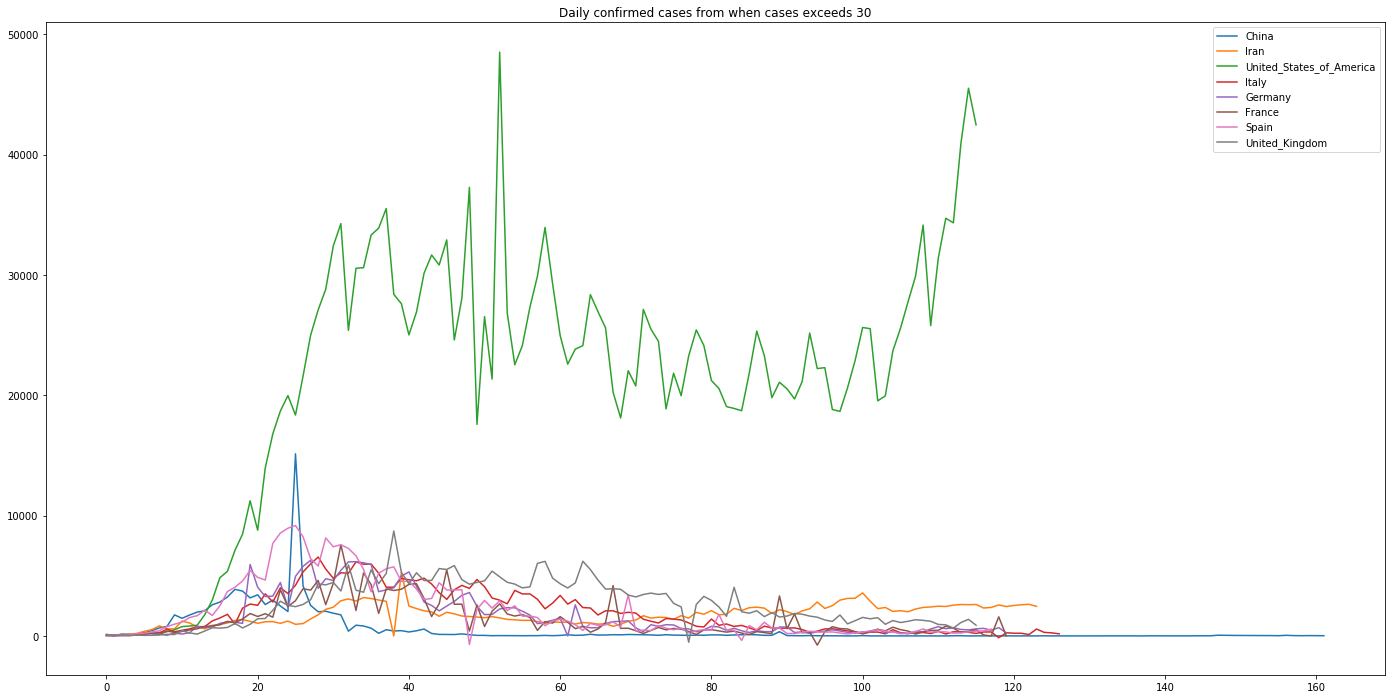

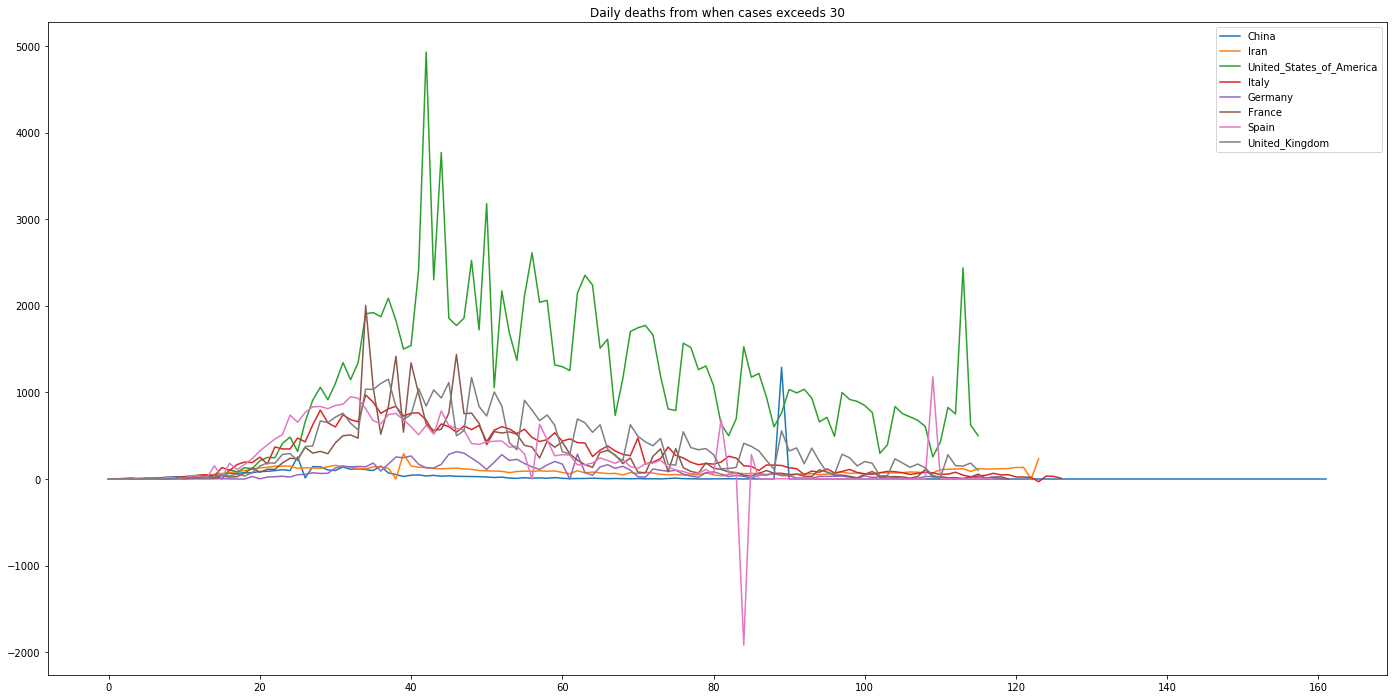

In [2]:
#STEP 5: Show a graph that overlays confirmed cases starting from the first day the number of cases exceeds 30
#The hypothesis that the virus has taken hold in these countries once the number of daily confirmed cases is more than 30

#Make a copy of the dataframe so we don't have to keep going back to the earlier cell
df = df3.copy()

#Add a new column for the Days from first confirmed case feature
df['Day'] = np.nan

#Loop through the countries and calculate the number of days from when the confirmed cases first exceed 30
for index, loc in locations.iterrows():
    country = loc.Location
    #Get the first date when the number of confirmed cases exceeded 30
    start_date = df[df['Location'] == country][df.Cases > 30].iat[0,0]

    #Calculate the number of days from the start date (i.e. set the Days column values)
    df.loc[df.Location == country, 'Day'] = (df.Date - start_date).dt.days

countries = ['China','Iran','United_States_of_America', 'Italy', 'Germany', 'France', 'Spain', 'United_Kingdom']
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Cases, label=country)

plt.legend()
plt.title(label='Daily confirmed cases from when cases exceeds 30', loc='center')
plt.show()
plt.close()

plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Deaths, label=country)

plt.legend()
plt.title(label='Daily deaths from when cases exceeds 30', loc='center')
plt.show()
plt.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


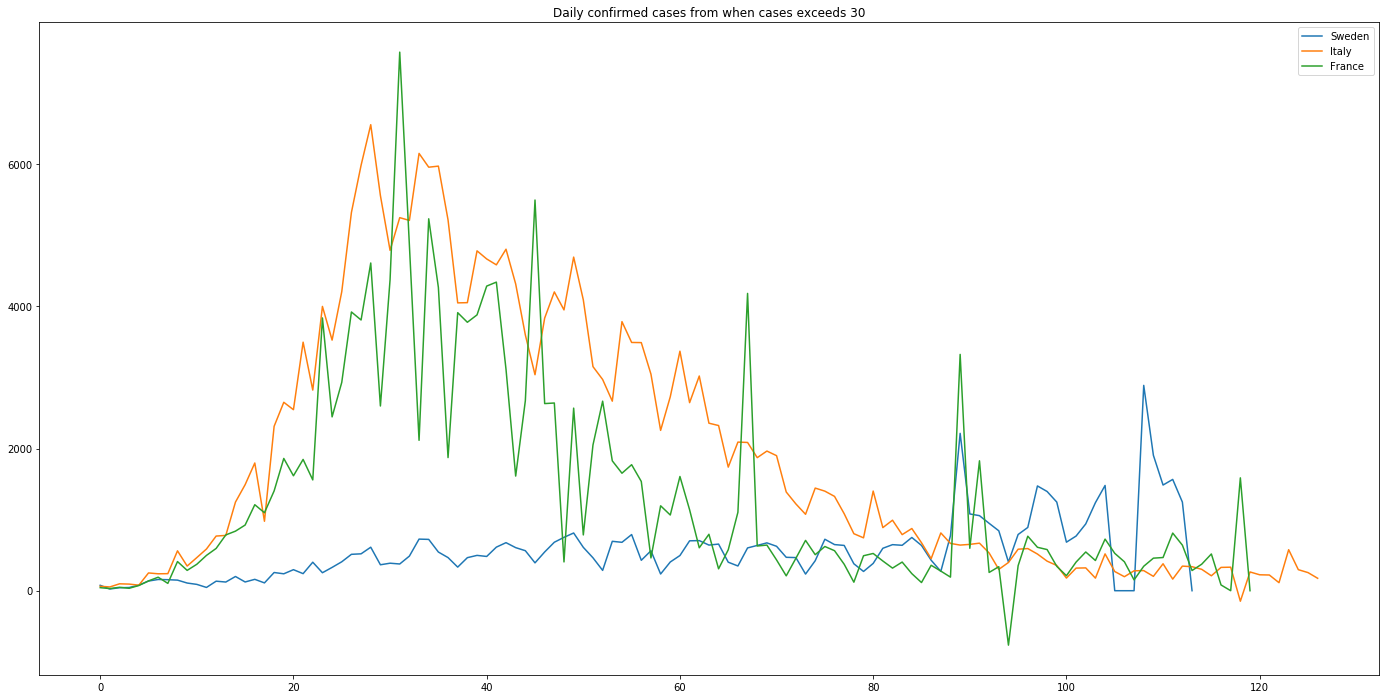

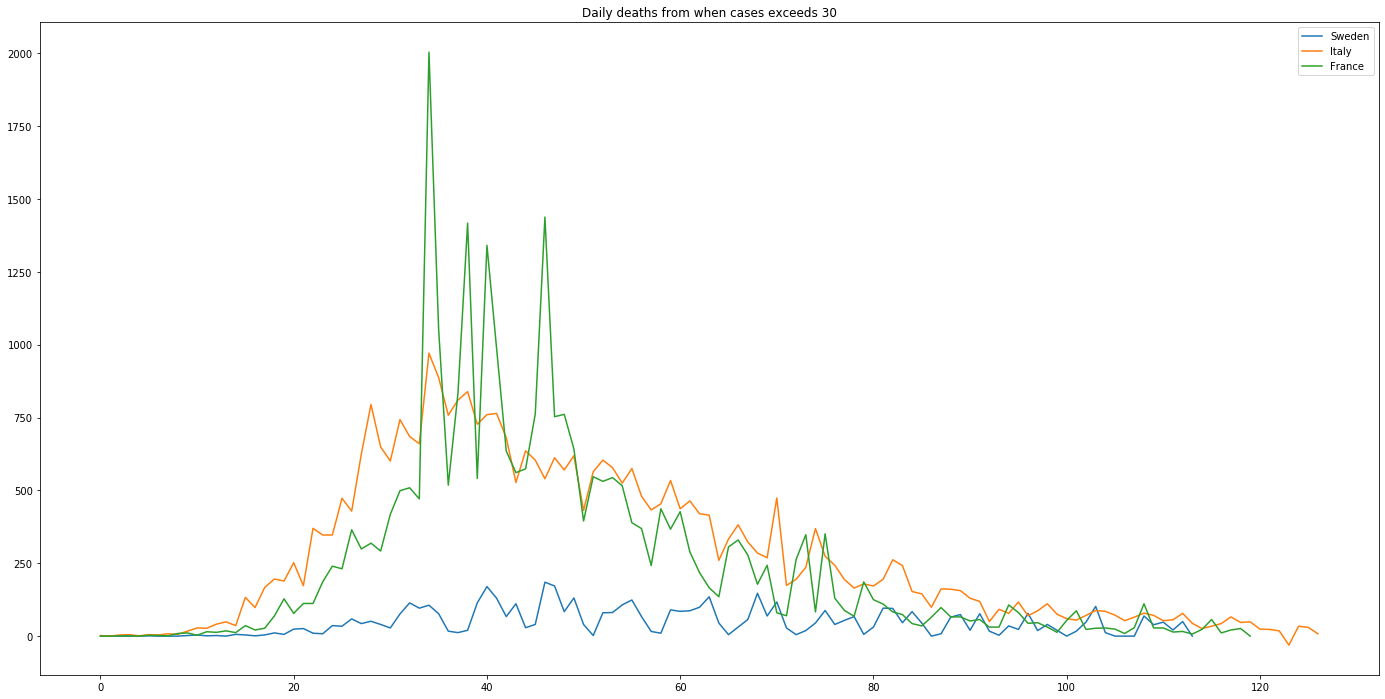

In [3]:
#STEP 5: Show a graph that overlays confirmed cases starting from the first day the number of cases exceeds 30
#The hypothesis that the virus has taken hold in these countries once the number of daily confirmed cases is more than 30

#Make a copy of the dataframe so we don't have to keep going back to the earlier cell
df = df3.copy()

#Add a new column for the Days from first confirmed case feature
df['Day'] = np.nan

#Loop through the countries and calculate the number of days from when the confirmed cases first exceed 30
for index, loc in locations.iterrows():
    country = loc.Location
    #Get the first date when the number of confirmed cases exceeded 30
    start_date = df[df['Location'] == country][df.Cases > 30].iat[0,0]

    #Calculate the number of days from the start date (i.e. set the Days column values)
    df.loc[df.Location == country, 'Day'] = (df.Date - start_date).dt.days

countries = ['Sweden','Italy','France']
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Cases, label=country)

plt.legend()
plt.title(label='Daily confirmed cases from when cases exceeds 30', loc='center')
plt.show()
plt.close()

plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Deaths, label=country)

plt.legend()
plt.title(label='Daily deaths from when cases exceeds 30', loc='center')
plt.show()
plt.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


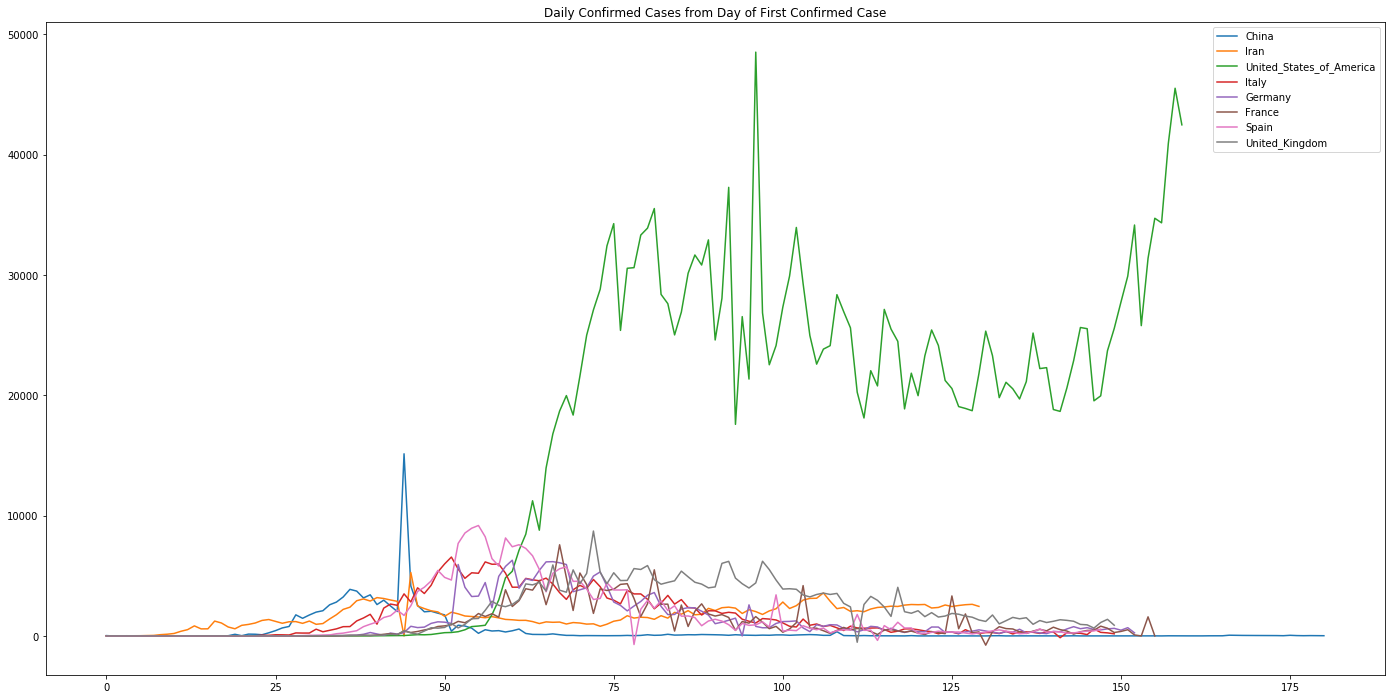

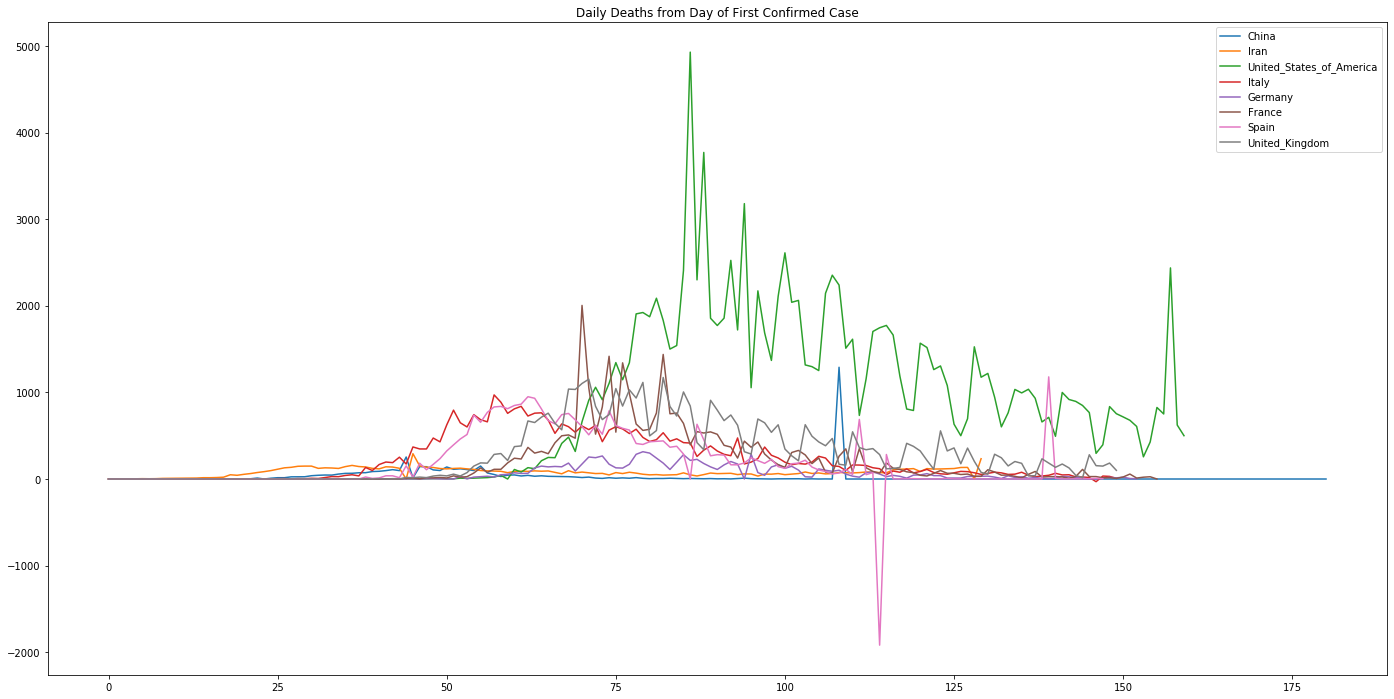

In [4]:
#Show a graph that overlays confirmed cases starting from the day of the first confirmed case
#The hypothesis that the virus has taken hold in these countries once the number of daily confirmed cases is more than 30

#Make a copy of the dataframe so we don't have to keep going back to the earlier cell
df = df3.copy()

#Add a new column for the Days from first confirmed case feature
df['Day'] = np.nan

#Loop through the countries and calculate the number of days from when the confirmed cases first exceed 30
for index, loc in locations.iterrows():
    country = loc.Location
    #Get the date for the first confirmed case
    start_date = df[df['Location'] == country][df.Cases != 0].iat[0,0]
    
    #Calculate the number of days from the start date (i.e. set the Days column values)
    df.loc[df.Location == country, 'Day'] = (df.Date - start_date).dt.days

countries = ['China','Iran','United_States_of_America', 'Italy', 'Germany', 'France', 'Spain', 'United_Kingdom']

plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Cases, label=country)

plt.legend()
plt.title(label='Daily Confirmed Cases from Day of First Confirmed Case', loc='center')
plt.show()
plt.close()

plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Deaths, label=country)

plt.legend()
plt.title(label='Daily Deaths from Day of First Confirmed Case', loc='center')
plt.show()
plt.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


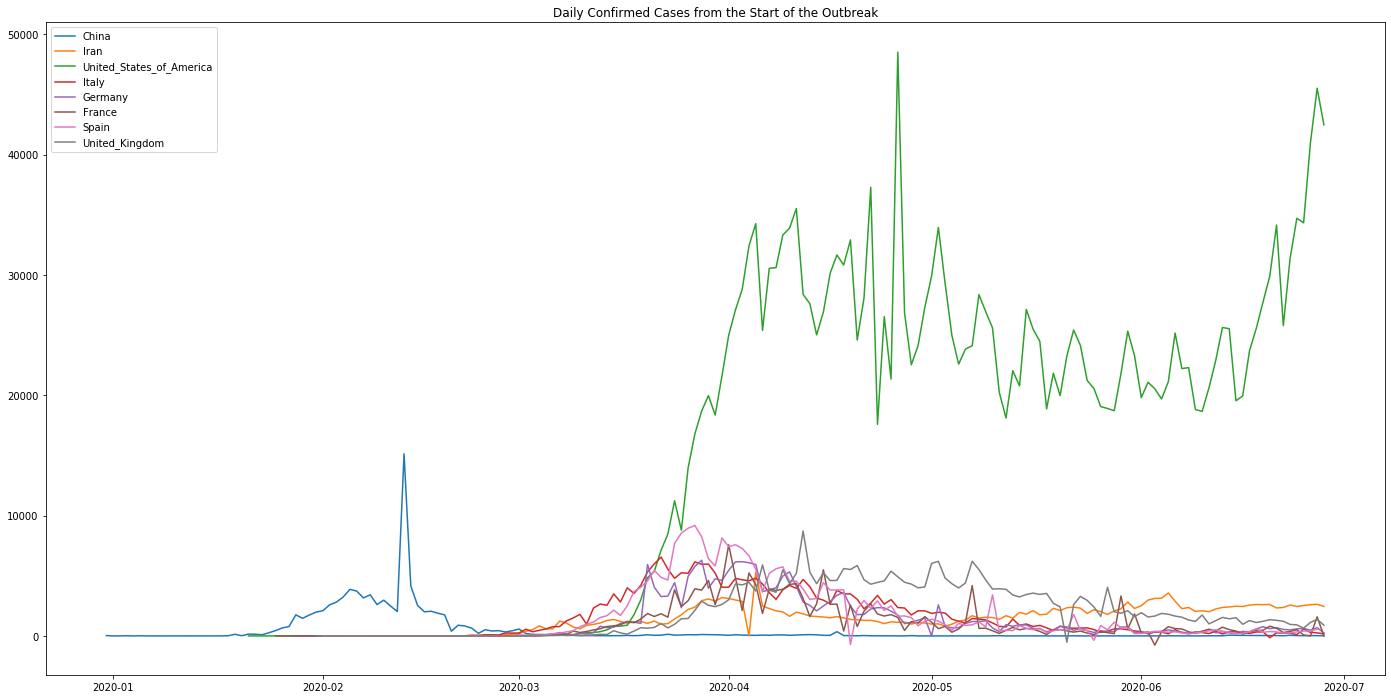

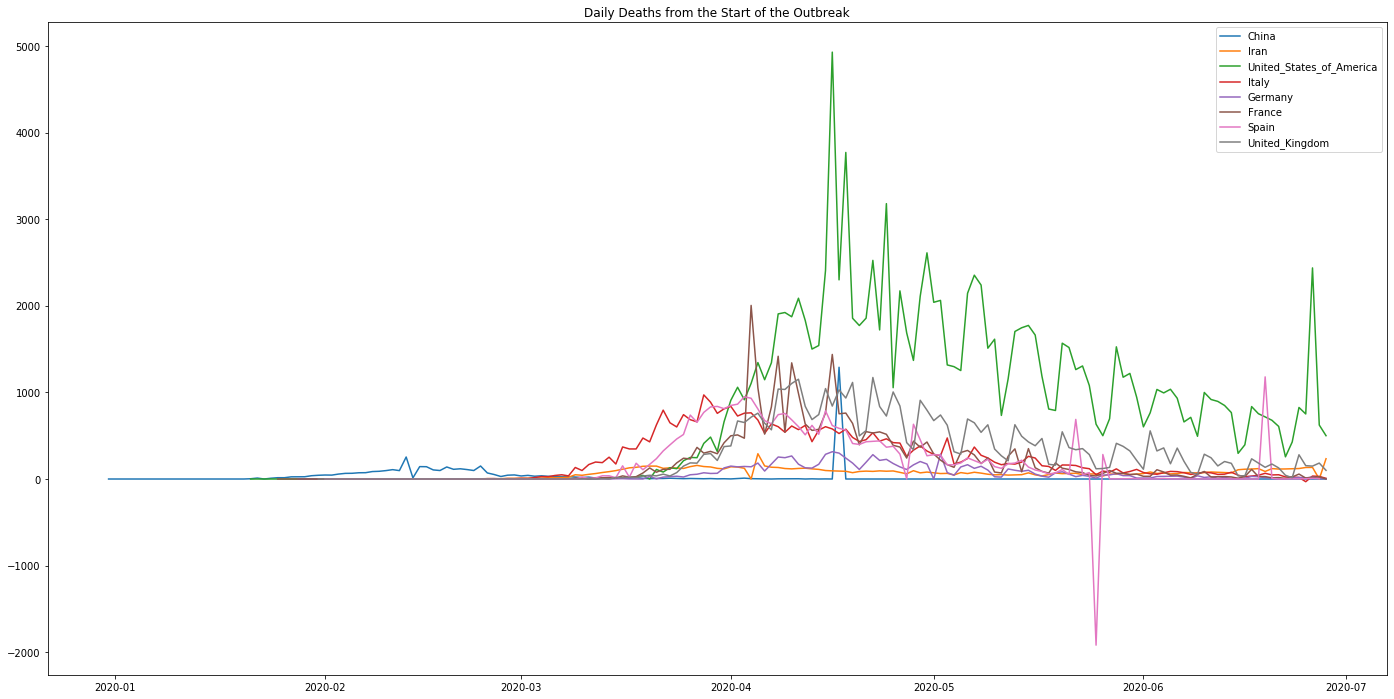

In [5]:
#Show a graph that overlays confirmed cases starting from the very beginning of the outbreak (12/01/2019)

#Make a copy of the dataframe so we don't have to keep going back to the earlier cell
df = df3.copy()

#Add a new column for the Days from first confirmed case feature
df['Day'] = np.nan

#Loop through the countries and calculate the number of days from when the confirmed cases first exceed 30
for index, loc in locations.iterrows():
    country = loc.Location
    #Get the date for the first confirmed case
    start_date = df[df['Location'] == country][df.Cases != 0].iat[0,0]
    
    #Calculate the number of days from the start date (i.e. set the Days column values)
    df.loc[df.Location == country, 'Day'] = (df.Date - start_date).dt.days

countries = ['China','Iran','United_States_of_America', 'Italy', 'Germany', 'France', 'Spain', 'United_Kingdom']

#Plot confirmed cases
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Date, pdf.Cases, label=country)

plt.legend()
plt.title(label='Daily Confirmed Cases from the Start of the Outbreak', loc='center')
plt.show()
plt.close()

#Plot deaths
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Date, pdf.Deaths, label=country)

plt.legend()
plt.title(label='Daily Deaths from the Start of the Outbreak', loc='center')
plt.show()
plt.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


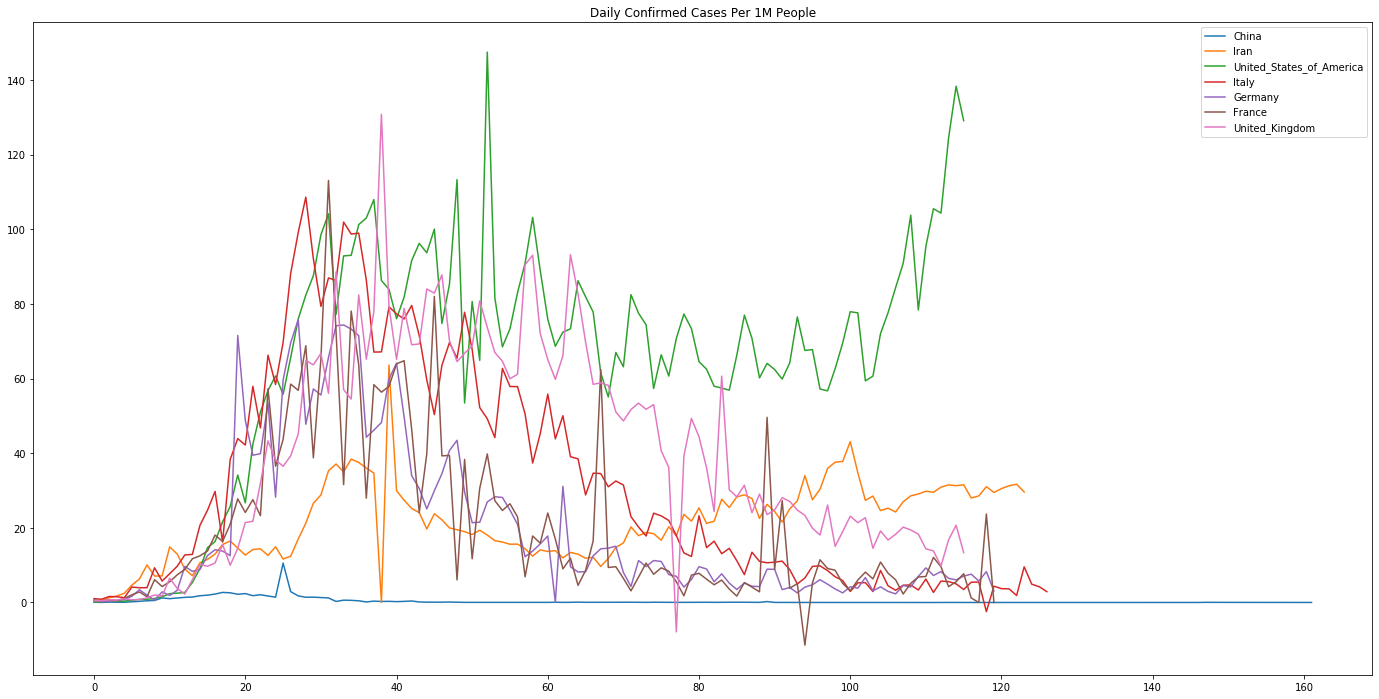

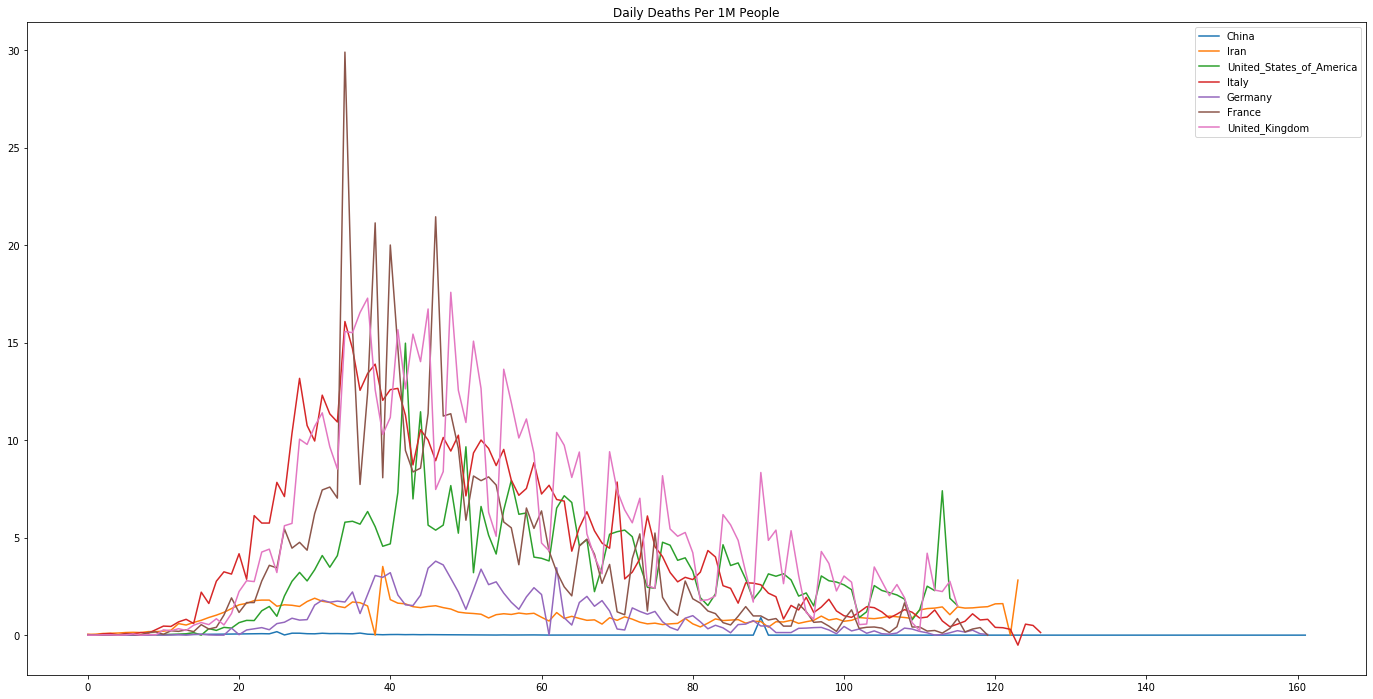

In [6]:
#Show a graph that overlays confirmed cases starting from the first day the number of cases exceeds 30
#This version shows the graph based on proportion to population (per 1M people)
#The hypothesis that the virus has taken hold in these countries once the number of daily confirmed cases is more than 30

#Make a copy so we don't have to keep going back to load the original data after making modifications
df = df3.copy()

#ourworldindata.org added a population column, so we can remove this code
#Load the population data
#popdf = pd.read_csv('COVID-19/ORIGINAL/countries-population-2019.csv')
#popdf = popdf.rename(columns={"country":"Location","population":"Population"})
#popdf
#Merge the population data into the main dataframe
#df = pd.merge(df, popdf[['Location', 'Population']], on='Location')

df['Proportional_Cases'] = df.Cases / df.Population * 1000000
df['Proportional_Deaths'] = df.Deaths / df.Population * 1000000

#Add a new column for the Days from first confirmed case feature
df['Day'] = np.nan

locations = locations.drop(locations[locations.Location == 'Cases_on_an_international_conveyance_Japan'].index)
locations = locations.drop(locations[locations.Location == 'Canada'].index)
#odf = odf.drop(odf[odf.Location == 'Cases_on_an_international_conveyance_Japan'].index)

#Loop through the countries and calculate the number of days from when the confirmed cases first exceed 30
for index, loc in locations.iterrows():
    country = loc.Location
    #Get the first date when the number of confirmed cases exceeded 30
    start_date = df[df['Location'] == country][df.Cases > 30].iat[0,0]

    #Calculate the number of days from the start date (i.e. set the Days column values)
    df.loc[df.Location == country, 'Day'] = (df.Date - start_date).dt.days

countries = ['China','Iran','United_States_of_America', 'Italy', 'Germany', 'France', 'United_Kingdom']

#Plot Confirmed Cases
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Proportional_Cases, label=country)

plt.legend()
plt.title(label='Daily Confirmed Cases Per 1M People', loc='center')
plt.show()
plt.close()

#Plot deaths
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Proportional_Deaths, label=country)

plt.legend()
plt.title(label='Daily Deaths Per 1M People', loc='center')
plt.show()
plt.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


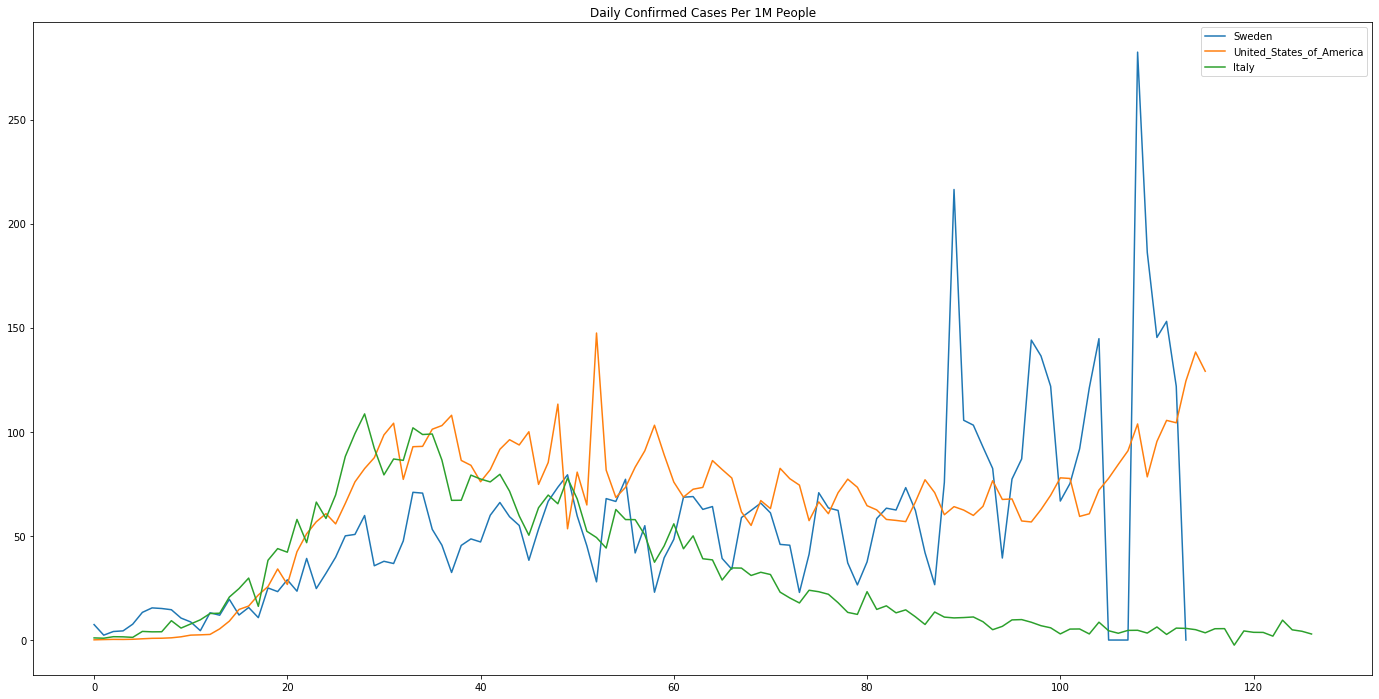

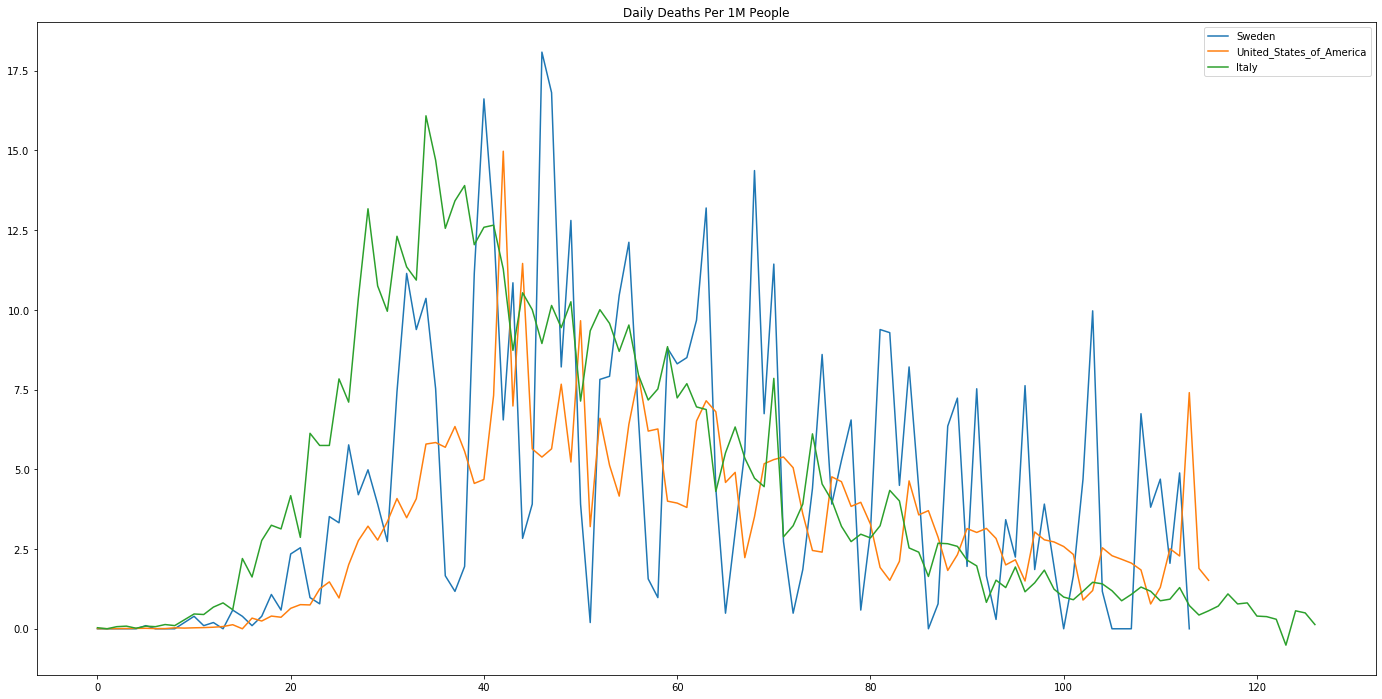

In [7]:
#Show a graph that overlays confirmed cases starting from the first day the number of cases exceeds 30
#This version shows the graph based on proportion to population (per 1M people)
#The hypothesis that the virus has taken hold in these countries once the number of daily confirmed cases is more than 30

#Make a copy so we don't have to keep going back to load the original data after making modifications
df = df3.copy()

#ourworldindata.org added a population column, so we can remove this code
#Load the population data
#popdf = pd.read_csv('COVID-19/ORIGINAL/countries-population-2019.csv')
#popdf = popdf.rename(columns={"country":"Location","population":"Population"})
#popdf
#Merge the population data into the main dataframe
#df = pd.merge(df, popdf[['Location', 'Population']], on='Location')

df['Proportional_Cases'] = df.Cases / df.Population * 1000000
df['Proportional_Deaths'] = df.Deaths / df.Population * 1000000

#Add a new column for the Days from first confirmed case feature
df['Day'] = np.nan

locations = locations.drop(locations[locations.Location == 'Cases_on_an_international_conveyance_Japan'].index)
locations = locations.drop(locations[locations.Location == 'Canada'].index)
#odf = odf.drop(odf[odf.Location == 'Cases_on_an_international_conveyance_Japan'].index)

#Loop through the countries and calculate the number of days from when the confirmed cases first exceed 30
for index, loc in locations.iterrows():
    country = loc.Location
    #Get the first date when the number of confirmed cases exceeded 30
    start_date = df[df['Location'] == country][df.Cases > 30].iat[0,0]

    #Calculate the number of days from the start date (i.e. set the Days column values)
    df.loc[df.Location == country, 'Day'] = (df.Date - start_date).dt.days

countries = ['Sweden','United_States_of_America','Italy']

#Plot Confirmed Cases
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Proportional_Cases, label=country)

plt.legend()
plt.title(label='Daily Confirmed Cases Per 1M People', loc='center')
plt.show()
plt.close()

#Plot deaths
plt.figure(figsize=[24,12])

for country in countries:
    pdf = df.copy()
    pdf = pdf[pdf.Location == country]
    pdf = pdf.drop(pdf[pdf.Day < 0].index)
    plt.plot(pdf.Day, pdf.Proportional_Deaths, label=country)

plt.legend()
plt.title(label='Daily Deaths Per 1M People', loc='center')
plt.show()
plt.close()

In [11]:
#REVISION HISTORY
#R05C00: Added code to automatically download and process the data from the ECDC website
#R06C00: Added charts to show the death rates